In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from src.dataset import ADE20KDataset, WallADE20KDataset, SimpleWallADE20KDataset
from IPython.display import IFrame
from ipywidgets import Output, Button, Layout, HBox, Image, VBox, IntProgress, Label
from ipywidgets import widgets
from IPython.display import display, clear_output
import PIL
import io
import os

import numpy as np

%matplotlib inline

In [2]:
DATA_ROOT = "../dataset/ADE20K_2021_17_01"

In [3]:
def display_sample_information(dataset, indices, show_mask=True):
    height = 6
    width = 6

    fig = Figure(figsize=(12, 12), dpi=100)
    fig.tight_layout()
    canvas = FigureCanvasAgg(fig)

    indices = indices[:int(width * height / 2)]
    for i, idx in enumerate(indices):
        ax_idx = i * 2 + 1
        mask_ax_idx = ax_idx + 1
        ax = fig.add_subplot(height, width, ax_idx)
        mask_ax = fig.add_subplot(height, width, mask_ax_idx)
        ax.axis('off')
        mask_ax.axis('off')

        image, mask = dataset[idx]

        if image.shape[0] == 3:
            image = image.transpose((1, 2, 0))
        if len(mask.shape) == 3:
            mask = mask.squeeze(axis=0)

        ax.imshow(image)
        mask_ax.imshow(mask)

    canvas.draw()
    buf = canvas.buffer_rgba()
    return np.asarray(buf)

In [4]:
wall_dataset = WallADE20KDataset(DATA_ROOT, mode='all')

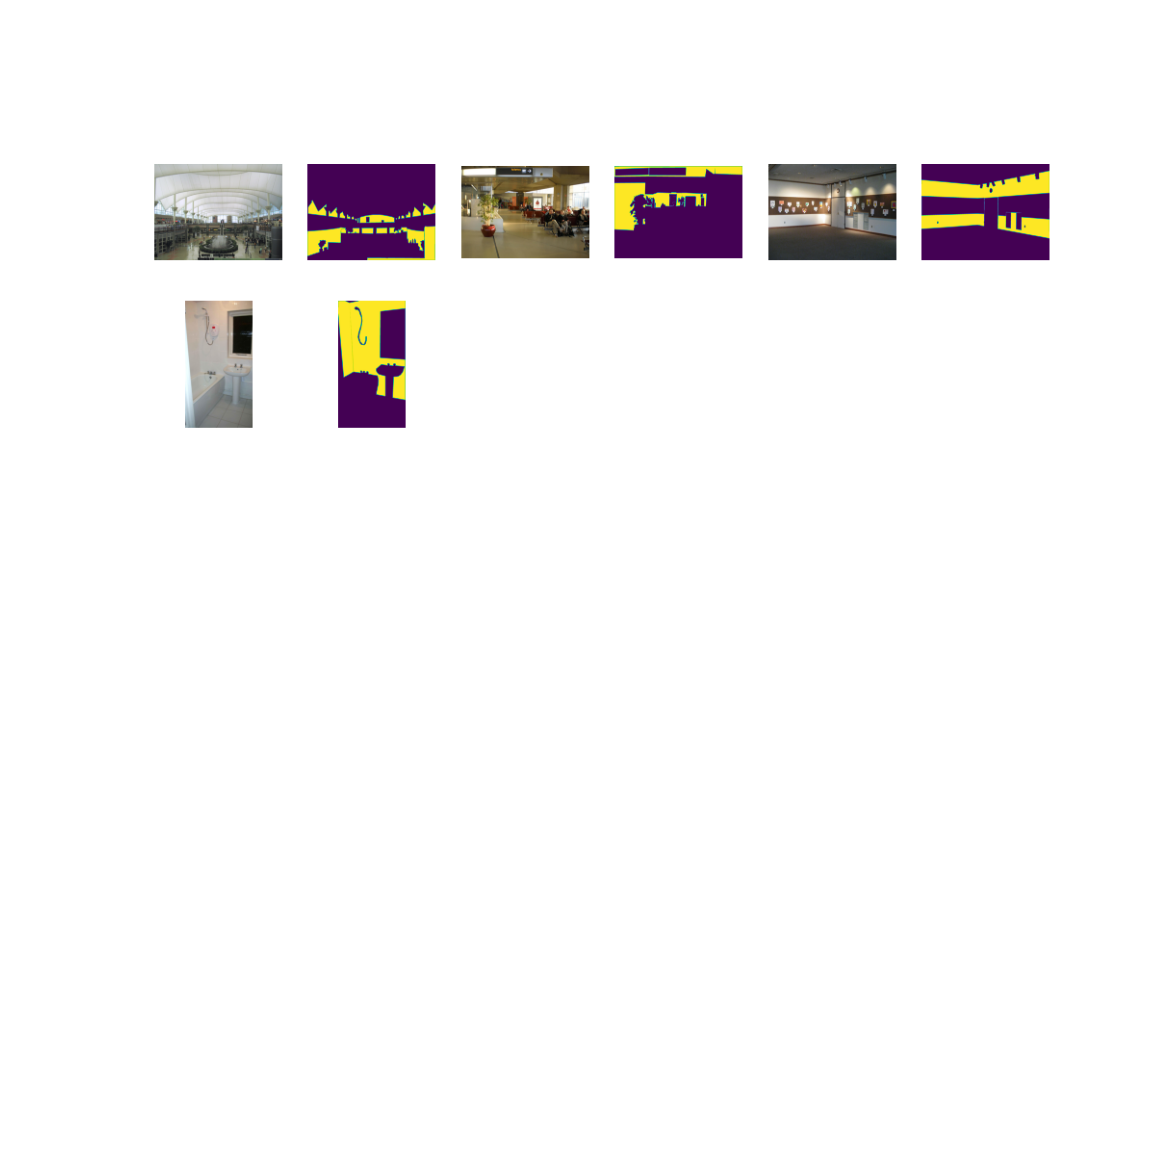

In [5]:
image = display_sample_information(wall_dataset, [0, 1, 2, 3])
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.axis('off');


In [6]:
def image_to_byte_array(image: PIL.Image) -> bytes:
    image_byte_arr = io.BytesIO()
    image.save(image_byte_arr, format='png')
    image_byte_arr = image_byte_arr.getvalue()
    return image_byte_arr

In [12]:
class SceneFilteringTool:

    def __init__(self, dataset: ADE20KDataset, output_dir):
        self.dataset = dataset

        self.scene_indices = {}
        self._build_scene_indices_dict()
        self.scene_names = list(sorted(self.scene_indices.keys()))
        self.position = 0

        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        # Remove annotated scenes
        self._remove_annotated_scenes('whitelist')
        self._remove_annotated_scenes('maybe')
        self._remove_annotated_scenes('blacklist')

    def _remove_annotated_scenes(self, label: str):
        filepath = self._get_output_file_for_label(label)
        if not os.path.exists(filepath):
            return
        with open(filepath) as f:
            scenes = f.read().splitlines()
            self.scene_names = [s for s in self.scene_names if s not in scenes]

    def _get_output_file_for_label(self, label: str):
        return os.path.join(self.output_dir, f'{label}.txt')

    def _build_scene_indices_dict(self):
        for i in range(0, len(self.dataset)):
            scene = self.dataset.index['scene'][i]
            if scene not in self.scene_indices:
                self.scene_indices[scene] = [i]
            else:
                self.scene_indices[scene].append(i)

    def _next_scene(self, label):
        # Save current scene label
        scene = self.scene_names[self.position]
        with open(self._get_output_file_for_label(label), 'a') as f:
            f.write(f'{scene}\n')

        self.position += 1
        if self.position == len(self.dataset) - 1:
            self.position = 0

        with self.frame:
            clear_output(wait=True)
            display(self._create_image_widget())

    def _create_image_widget(self):
        scene = self.scene_names[self.position]
        sample_indices = self.scene_indices[scene]

        image = display_sample_information(self.dataset, sample_indices)
        image = PIL.Image.fromarray(image)
        image = image_to_byte_array(image)
        scene_label = Label(scene)

        progress = IntProgress(value=self.position, min=0, max=len(self.scene_names) - 1)
        progress_label = Label(f'{self.position+1}/{len(self.scene_names)}')
        progress_box = HBox((progress, progress_label))

        widget = VBox((progress_box, scene_label, Image(value=image)))

        return widget

    def start(self):
        # self.frame = Output(layout=Layout(height="700px", max_width="300px"))
        self.frame = Output()

        whitelist_button = Button(description="WHITELIST")
        whitelist_button.on_click(lambda b: self._next_scene('whitelist'))

        maybe_button = Button(description="MAYBE")
        maybe_button.on_click(lambda b: self._next_scene('maybe'))

        blacklist_button = Button(description="BLACKLIST")
        blacklist_button.on_click(lambda b: self._next_scene('blacklist'))

        buttons_row = HBox((blacklist_button, maybe_button, whitelist_button))

        image_widget = self._create_image_widget()
        with self.frame:
            display(image_widget)

        display(buttons_row)
        display(self.frame)

In [13]:
tool = SceneFilteringTool(dataset=wall_dataset, output_dir='label')
tool.start()

Output()